<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/notebooks/natalia/JDI_GC_cut_tiles_from_height_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating height map tiles based on RGB tiles coordinates to obtain input data compatible with the annotation masks

The RGB images vary from the height maps in terms of size, resolution and coverage. The annotations were created for specific tiles of the RGB data. These tiles are saved as png files, which means they are no longer georeferenced. The task now is aligning them with the height data to create height tiles compatible with the annotation masks.

Approach: reuse Lynxx code for generating RGB tiles, but save them as .tif (instead of .png) to keep the geo references, then use those references to cut out the same areas from the height maps.

In [ ]:
import os
from osgeo import gdal
import json

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  70472      0 --:--:-- --:--:-- --:--:-- 70472
OK
30 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.6_amd64.deb ...
Unpacking gcsfuse (0.41.6) ...
Setting up gcsfuse (0.41.6) ...


In [ ]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/09/04 19:05:49.108643 Start gcsfuse/0.41.6 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/09/04 19:05:49.119170 Opening GCS connection...
2022/09/04 19:05:49.510437 Mounting file system "justdiggit-drone"...
2022/09/04 19:05:49.538607 File system has been successfully mounted.


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Regenerate the RGB tiles, but in GeoTiff format

Note: since only a portion of tiles were annotated, I'll be saving the .tif equivalents for the annotated tiles only!

In [ ]:
output_path = "/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif"

In [ ]:
annotations_file = '/content/justdiggit-drone-data/label_sample/Annotations_trees_only.json'
annotations = json.load(open(annotations_file))

In [ ]:
annotations.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
tiles_with_annotations = list(set([d['file_name'] for d in annotations['images']]))

In [ ]:
tiles_with_annotations[0]

'chaludewa_year_2019_tile_15000_7000.png'

In [ ]:
villages = ["chaludewa", "bumila", "ikengwa", "kisima", "loo", "mapango"]

In [ ]:
# Cut large geotiff in tiles including geocoordinates
for location in villages:
  in_path = f'/content/justdiggit-drone-data/rdp-2019/{location}/ortho_{location}_2019.tif'

  year = '2019'
 
  out_path = f'{output_path}/{location}/{year}/'
  if os.path.exists(out_path) == False:
    os.makedirs(out_path)

  output_filename = f'{location}_year_{year}_tile_'
  
  tile_size_x = 1000
  tile_size_y = 1000
  
  ds = gdal.Open(in_path)
  band = ds.GetRasterBand(1)
  xsize = band.XSize
  ysize = band.YSize
  
  for i in range(0, xsize, tile_size_x):
      for j in range(0, ysize, tile_size_y):
         
          # command line command to run:         
          com_string = "gdal_translate -of GTiff -ot Byte -srcwin " + str(i)+ ", " \
          + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " \
          + str(in_path) + " " + str(out_path) + str(output_filename) + str(i) \
          + "_" + str(j) + ".tiff"
          tile_name = output_filename +str(i) + "_" + str(j)
          tile_name_png = tile_name + ".png"
          # check if this tile has any annotations and if so, save it
          if tile_name_png in tiles_with_annotations:
            os.system(com_string)
  print("Done")


Done
Done
Done
Done
Done
Done


# Cut out equivalent areas from the height maps

In [ ]:
import gdal
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np

## Perform this task on a single tile

In [ ]:
ex_rgb_tile_path = "/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/bumila/2019/bumila_year_2019_tile_8000_14000.tiff"

In [ ]:
ex_rgb_tile = gdal.Open(ex_rgb_tile_path)

In [ ]:
ulx, xres, xskew, uly, yskew, yres  = ex_rgb_tile.GetGeoTransform()
lrx = ulx + (ex_rgb_tile.RasterXSize * xres)
lry = uly + (ex_rgb_tile.RasterYSize * yres)

In [ ]:
ex_height_map_path = "/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/bumila.tiff"

In [ ]:
ex_out_path = "/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/ex.tif"

In [ ]:
ex_height_map = gdal.Open(ex_height_map_path)

In [ ]:
command = f'gdal_translate -projwin {ulx} {uly} {lrx} {lry} "{ex_height_map_path}" "{ex_out_path}"'
print(command)

gdal_translate -projwin 36.1583535607124 -5.1102247978904805 36.1588654747124 -5.1107380908904805 "/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/bumila.tiff" "/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/ex.tif"


In [ ]:
os.system(command)

0

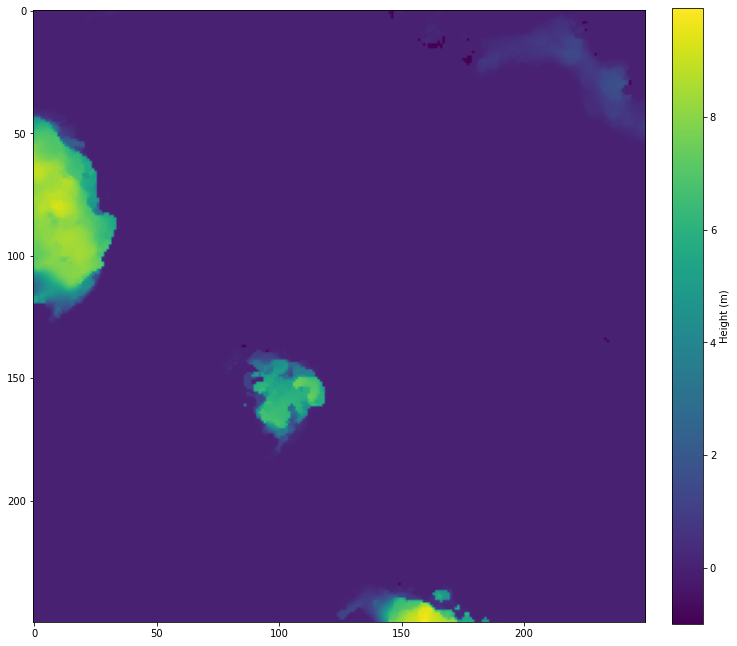

In [ ]:
height_tile = gdal.Open(ex_out_path).ReadAsArray()
plt.figure(figsize=(12,16))
plot = plt.imshow(height_tile)
plt.colorbar(plot, fraction=0.046, pad=0.04, label = "Height (m)")
plt.show()

In [ ]:
height_tile.shape

(250, 250)

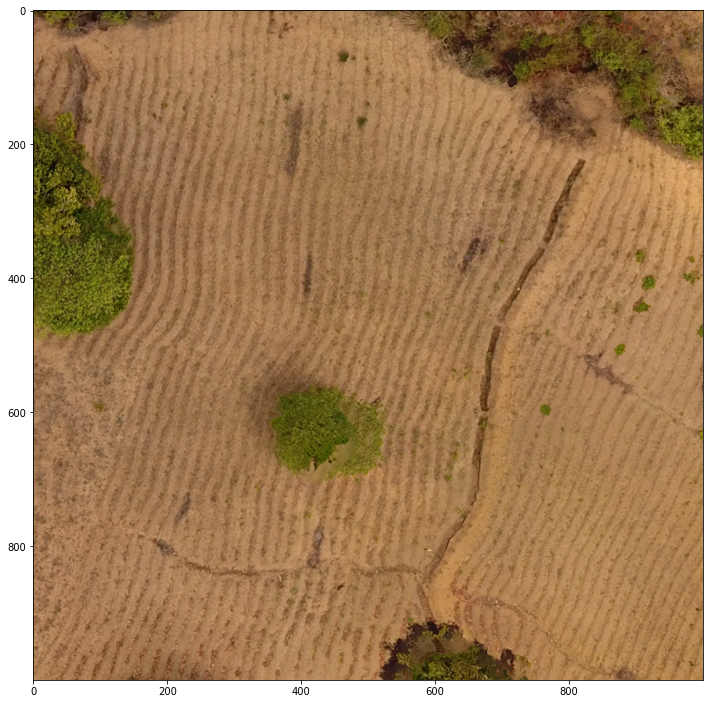

In [ ]:
ex_rgb_tile_array = ex_rgb_tile.ReadAsArray()
ex_rgb_tile_array = np.swapaxes(np.swapaxes(ex_rgb_tile_array,0,2),0,1)
plt.figure(figsize=(12,16))
plot = plt.imshow(ex_rgb_tile_array)
plt.show()

## Perform this task on all tiles

In [ ]:
for village in villages:
  rgb_tiles_path = f"/content/drive/MyDrive/AI4Trees/google_cloud_data/RGB_tiles_tif/{village}/2019/"
  height_tiles_path = f"/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/tiles_annotated/{village}/2019"
  full_height_map_path = f"/content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/{village}.tiff"
  if os.path.exists(height_tiles_path) == False:
    os.makedirs(height_tiles_path)
  for tile_name in os.listdir(rgb_tiles_path):
    rgb_tile = gdal.Open(os.path.join(rgb_tiles_path, tile_name))
    ulx, xres, xskew, uly, yskew, yres  = rgb_tile.GetGeoTransform()
    lrx = ulx + (rgb_tile.RasterXSize * xres)
    lry = uly + (rgb_tile.RasterYSize * yres)
    output_path = os.path.join(height_tiles_path, tile_name)
    command = f'gdal_translate -projwin {ulx} {uly} {lrx} {lry} "{full_height_map_path}" "{output_path}"'
    os.system(command)

## Check if tiles were cut correctly

In [ ]:
def compare_rgb_and_height_tiles(rgb_tiles_path, height_tiles_path, num_of_tiles=1):
  rgb_tiles = os.listdir(rgb_tiles_path)
  count = 0
  fig, axes = plt.subplots(num_of_tiles,2, figsize=(20,10*num_of_tiles))
  while count < num_of_tiles:
    tile_name = rgb_tiles[count]
    rgb_tile = gdal.Open(os.path.join(rgb_tiles_path, tile_name)).ReadAsArray()
    rgb_tile = np.swapaxes(np.swapaxes(rgb_tile,0,2),0,1)
    axes[count,0].imshow(rgb_tile)
    height_tile = gdal.Open(os.path.join(height_tiles_path, tile_name)).ReadAsArray()
    axes[count,1].imshow(height_tile)
    count = count+1
  plt.show()

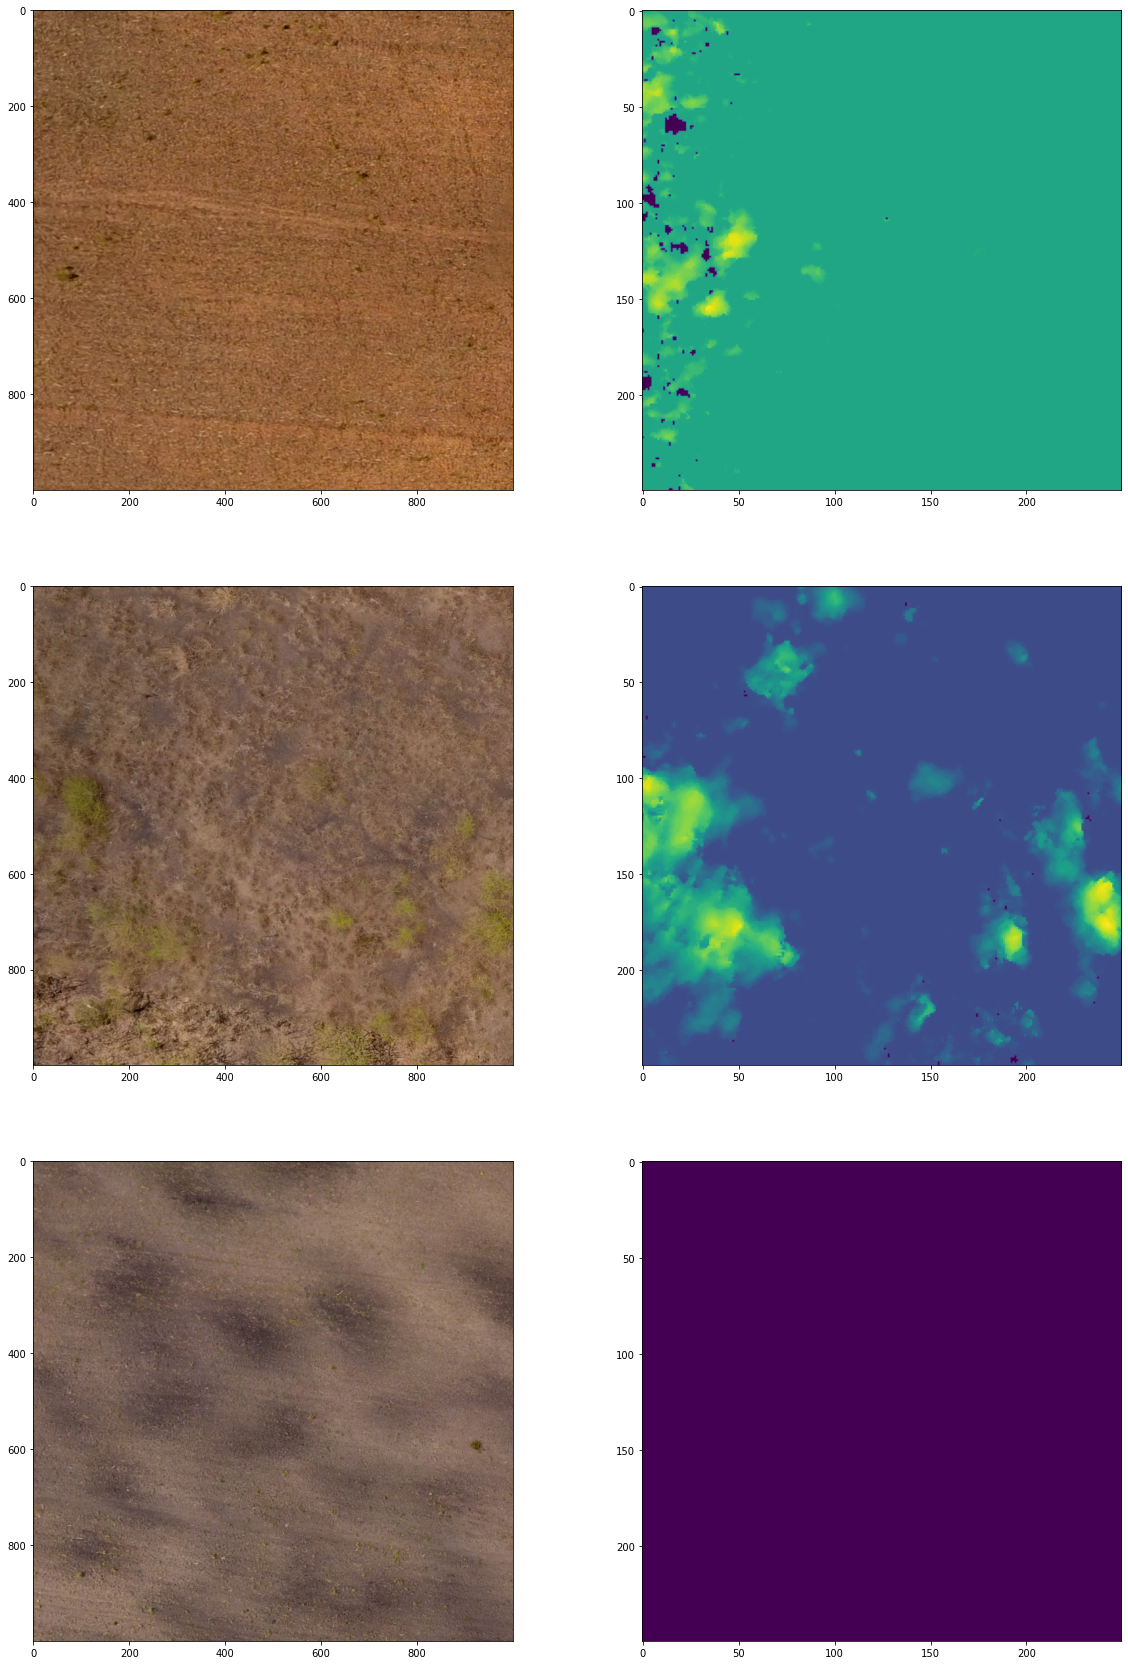

In [ ]:
compare_rgb_and_height_tiles(rgb_tiles_path, height_tiles_path, 3)